In [255]:
import quandl
import pandas as pd 
import numpy as np

quandl.ApiConfig.api_key = 'B_m2qXx_fP2zr7VVzYtt'
start = '2017-10-18'
end = '2018-10-18'
df12 = quandl.get('BOE/XUDLDSY',start_date = start, end_date = end)
df6 = quandl.get('BOE/XUDLDS6',start_date = start, end_date = end)
df3 = quandl.get('BOE/XUDLDS3',start_date = start, end_date = end)
df1 = quandl.get('BOE/XUDLDS1',start_date = start, end_date = end)
df12_6 = df12.merge(df6,how='inner',on='Date')
df3_1 = df3.merge(df1,how='inner',on='Date')
df = df12_6.merge(df3_1,how='inner',on='Date')
df = df.rename(columns={'Value_x_x': '12_months'})
df = df.rename(columns={'Value_y_x': '6_months'})
df = df.rename(columns={'Value_x_y': '3_months'})
df = df.rename(columns={'Value_y_y': '1_month'})
d = {'Index': np.arange(len(df.index))}
d = pd.DataFrame(data=d)
#df['Date'] = df.index
df['Index'] = d.index
df = df.set_index('Index')

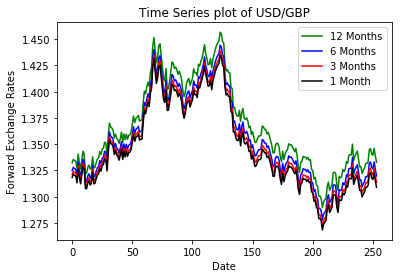

In [256]:
import matplotlib.pyplot as plt
plt.plot(df.index, df['12_months'],'g-', label = '12 Months')
plt.plot(df.index, df['6_months'],'b-', label = '6 Months')
plt.plot(df.index, df['3_months'],'r-', label = '3 Months')
plt.plot(df.index, df['1_month'],'k-', label = '1 Month')
plt.title('Time Series plot of USD/GBP');
plt.xlabel('Date');
plt.ylabel('Forward Exchange Rates');
plt.legend()
plt.show()

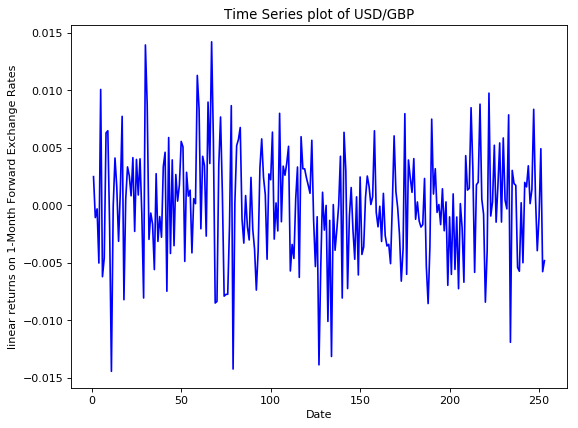

In [257]:
linrets = np.log(df/df.shift(1)).dropna() #linear returns
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(linrets.index, linrets['1_month'],'b-')
plt.title('Time Series plot of USD/GBP');
plt.xlabel('Date');
plt.ylabel('linear returns on 1-Month Forward Exchange Rates');
plt.show()

In [258]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
#from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [259]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

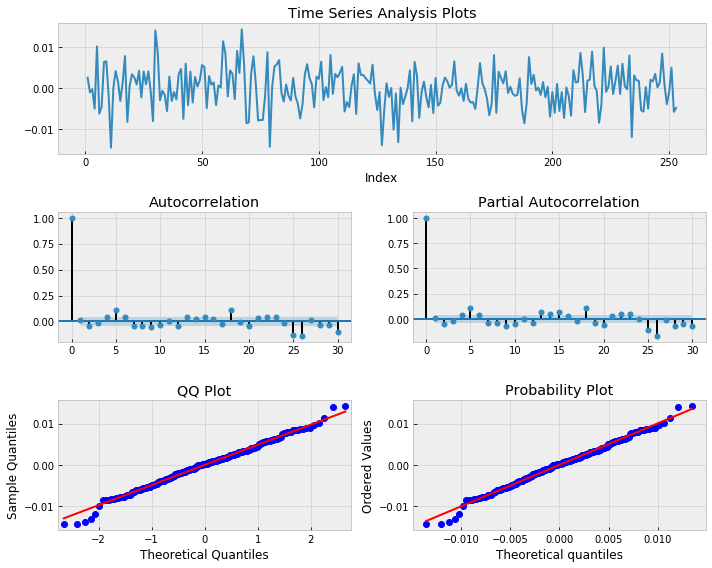

In [260]:
max_lag = 30

n = int(500) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

_ = tsplot(linrets['1_month'], lags=max_lag)

In [267]:
%%latex
\begin{align}
\large{ARMA(p,q) \ model}
\\
X_{t} & = \sum^{p}_{i=1}\alpha_{i}X_{t-i} + \sum^{q}_{j=0} \beta_{j} \epsilon_{t-j}
\\
\end{align}

<IPython.core.display.Latex object>

In [261]:
mdl = smt.ARIMA(linrets['1_month'], order=(2,1, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

/Users/nataliewong/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/nataliewong/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:              D.1_month   No. Observations:                  252
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 981.615
Method:                           mle   S.D. of innovations              0.005
Date:                Sun, 21 Oct 2018   AIC                          -1953.231
Time:                        11:22:12   BIC                          -1935.584
Sample:                             1   HQIC                         -1946.130
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ar.L1.D.1_month     0.1318      0.613      0.215      0.830      -1.070       1.334
ar.L2.D.1_month    -0.0526      0.064     -0.816      0.415      -0.179       0.074
ma.L1.D.1_month    -1.1089      

ARIMA(p,d,q) is a natural extension to the class of ARMA models. When applying ARMA model to our Time Series, python suggests that the timeseries is not stationary. However time series can be made stationary by differencing. We took the first differencing (d=1) of the 1-month Forward Exhange Rate and proved that it equals white noise. 

ARIMA(p,d,q) enables us to transform nonstationary random walk  to stationary white noise by first-differencing.

# References:

## Forecasting Exchange Rates Using Time Series Analysis: The sample of the currency of Kazakhstan 